In [124]:
import wandb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [125]:
wandb.login()

True

In [126]:
api = wandb.Api()


runs = []
# runs += api.runs("fsoconut/generative-modelling", {"group": "MNIST-base"})
runs += api.runs("fsoconut/generative-modelling", {"group": "MNIST-base-fid"})
runs += api.runs("fsoconut/generative-modelling", {"group": "MNIST-base-fid-acc"})

# Get training accuracy history for each run
results = []
for run in tqdm(runs[:50]):
    if run.config['sgld_optimizer'] == 'torch.optim.SGD(x, lr=1)' and run.config['sgld_scheduler'] == 'torch.optim.lr_scheduler.ConstantLR(x, factor=1)':
        history = run.history()
        processed_history = {}

        # Accuracy
        acc = history['Training/acc'].values
        processed_history['Training/acc'] = {
            'x': history['batch'][~np.isnan(acc)],
            'y': acc[~np.isnan(acc)]
        }

        # FID
        fid = history['Training/fid'].values
        processed_history['Training/fid'] = {
            'x': history['batch'][~np.isnan(fid)],
            'y': fid[~np.isnan(fid)]
        }

        # Energy Loss
        energy_loss = history['Training/loss_gen'].values
        processed_history['Training/loss_gen'] = {
            'x': history['batch'][~np.isnan(energy_loss)],
            'y': energy_loss[~np.isnan(energy_loss)]
        }
        results.append(processed_history)

100%|██████████| 22/22 [00:05<00:00,  3.92it/s]


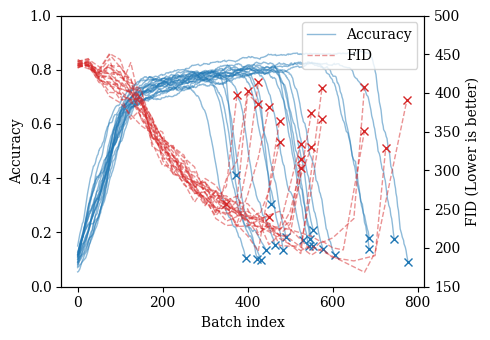

In [174]:
plt.rcParams['font.family'] = 'serif'

fig = plt.figure(figsize=(5, 3.5))

# Create second y-axis
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ALPHA = .5
LINEWIDTH = 1
COUNT = 20
for i, result in enumerate(results[:COUNT]):
    # Plot accuracy and loss on left y-axis
    acc = result['Training/acc']['y']
    acc_width = 50
    acc_smooth = np.convolve(acc, np.ones(acc_width)/acc_width, mode='same')
    ax1.plot(result['Training/acc']['x'], acc_smooth, 
             label='Accuracy' if i == 0 else "", color='tab:blue', linewidth=LINEWIDTH, alpha=ALPHA)
    
    # Add 'x' marker at the end of accuracy curve
    last_x = result['Training/acc']['x'].iloc[-1]
    last_y = acc_smooth[-1]
    ax1.plot(last_x, last_y, 'x', color='tab:blue', markersize=6, markeredgewidth=1, alpha=1)
    
    # Plot FID on right y-axis
    ax2.plot(result['Training/fid']['x'], result['Training/fid']['y'],
             label='FID' if i == 0 else "", color='tab:red', linestyle='--', linewidth=LINEWIDTH, alpha=ALPHA)
    
    # Add 'x' marker at the end of FID curve
    last_x = result['Training/fid']['x'].iloc[-1]
    last_y = result['Training/fid']['y'][-1]
    ax2.plot(last_x, last_y, 'x', color='tab:red', markersize=6, markeredgewidth=1, alpha=1)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.set_ylim(0,1)
ax2.set_ylim(150,500)
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('FID (Lower is better)')
ax1.set_xlabel('Batch index')

# Log Scale
# ax1.set_xscale('log')
# x_max = max([max(result['Training/acc']['x']) for result in results])
# ax1.set_xlim(100, x_max)

plt.tight_layout()
fig.savefig('training_curves.png', dpi=300)
plt.show()

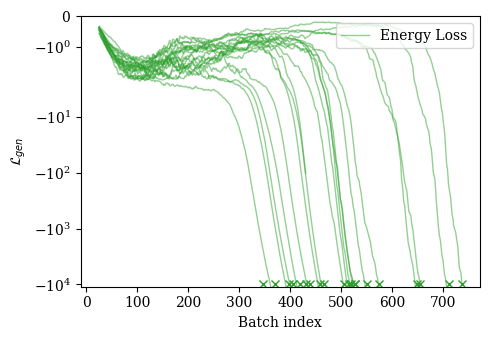

In [173]:
plt.rcParams['font.family'] = 'serif'

fig = plt.figure(figsize=(5, 3.5))
ax = fig.add_subplot(111)

for i, result in enumerate(results):
    # Plot energy loss
    loss = result['Training/loss_gen']['y']
    loss_width = 50
    loss_smooth = np.convolve(loss, np.ones(loss_width)/loss_width, mode='valid')[1:]
    valid_x = result['Training/loss_gen']['x'][loss_width//2:-loss_width//2]
    ax.plot(valid_x, loss_smooth,
            label='Energy Loss' if i == 0 else "", color='tab:green', linewidth=1, alpha=0.5)
    
    # Add 'x' marker at the end of loss curve
    last_x = valid_x.iloc[-1]
    last_y = -10000
    ax.plot(last_x, last_y, 'x', color='tab:green', markersize=6, markeredgewidth=1)

ax.legend(loc='upper right')
ax.set_ylabel('$\mathcal{L}_{gen}$')
ax.set_ylim(-11000,0)
ax.set_yscale('symlog')
ax.set_xlabel('Batch index')

plt.tight_layout()
fig.savefig('training_curves_energy.png', dpi=300)
plt.show()
